In [1]:
# Install TensorFlow
!pip install -q tensorflow-gpu==2.0.0-rc0

try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.0.0-rc0 (from versions: 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.6.5, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.7.2, 2.7.3, 2.7.4, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.12.0)
ERROR: No matching distribution found for tensorflow-gpu==2.0.0-rc0


2023-05-30 12:18:41.997261: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


2.5.0


In [2]:
# More importing common libraries

from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [3]:
# Load the MNIST Data

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Scale the inputs in range of (-1, +1) for better training
x_train, x_test = x_train / 255.0 * 2 - 1, x_test / 255.0 * 2 - 1


In [4]:
print ("x_train.shape:" ,x_train.shape)
print ("x_test.shape:" ,x_test.shape)

x_train.shape: (60000, 28, 28)
x_test.shape: (10000, 28, 28)


In [5]:
# Flatten the data
N, H, W = x_train.shape
D = H * W
x_train = x_train.reshape(-1, D)
x_test = x_test.reshape(-1, D)

In [6]:
print ("x_train.shape:" ,x_train.shape)
print ("x_test.shape:" ,x_test.shape)

x_train.shape: (60000, 784)
x_test.shape: (10000, 784)


In [7]:
# Dimensionality of the latent space
latent_dim = 100

In [8]:
# Defining the generator model
def build_generator(latent_dim):
  i = Input(shape=(latent_dim,))
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(D, activation='tanh')(x)

  model = Model(i, x)
  return model

In [9]:
# Defining the discriminator model
def build_discriminator(img_size):
  i = Input(shape=(img_size,))
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
  x = Dense(1, activation='sigmoid')(x)

  
  model = Model(i, x)
  return model

In [10]:
# Compile both models in preparation for training

# Build and compile the discriminator
discriminator = build_discriminator(D)
discriminator.compile ( loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

# Build and compile the combined model
generator = build_generator(latent_dim)

2023-05-30 12:18:46.280719: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-30 12:18:46.280747: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-30 12:18:46.280804: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ctpc09): /proc/driver/nvidia/version does not exist
2023-05-30 12:18:46.281036: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
generator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               25856     
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_4 (Dense)              (None, 512)               131584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              525312    
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024)              4096

In [12]:
discriminator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Create an input to represent noise sample from latent space
z = Input(shape=(latent_dim,))

z.shape

TensorShape([None, 100])

In [14]:
# Pass noise through generator to get an image
img = generator(z)

In [15]:
img

<KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'model_1')>

In [16]:
# Make sure only the generator is trained
discriminator.trainable = False

In [17]:
# The true output is fake, but we label them real!
# Passing the output of Generator to the Discriminator

fake_pred = discriminator(img)

In [18]:
# Create the combined model object
combined_model_gen = Model(z, fake_pred)

In [19]:
# Compile the combined model
combined_model_gen.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [20]:
# Config

batch_size = 32
epochs = 30000
sample_period = 200 # every `sample_period` steps generate and save some data"

In [21]:

# Create batch labels to use when calling train_on_batch
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

# Store the losses
d_losses = []
g_losses = []

# Create a folder to store generated images
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

In [22]:
# A function to generate a grid of random samples from the generator and save them to a file

def sample_images(epoch):
  rows, cols = 5, 5
  noise = np.random.randn(rows * cols, latent_dim)
  imgs = generator.predict(noise)

  # Rescale images 0 - 1
  imgs = 0.5 * imgs + 0.5

  fig, axs = plt.subplots(rows, cols)
  idx = 0
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(H, W), cmap='gray')
      axs[i,j].axis('off')
      idx += 1
  fig.savefig("gan_images/%d.png" % epoch)
  plt.close()

In [23]:
### Train the GAN

In [42]:
# Main training loop
for epoch in range(epochs):
  ###########################
  ### Train discriminator ###
  ###########################
  
  # Select a random batch of images
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  real_imgs = x_train[idx]
  
  # Generate fake images
  noise = np.random.randn(batch_size, latent_dim)
  fake_imgs = generator.predict(noise)
  
  # Train the discriminator
  # both loss and accuracy are returned
  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
  d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
  d_loss = 0.5 * (d_loss_real + d_loss_fake)
  d_acc  = 0.5 * (d_acc_real + d_acc_fake)
  
  
  #######################
  ### Train generator ###
  #######################
  
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model_gen.train_on_batch(noise, ones)
  
  # do it again!
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model_gen.train_on_batch(noise, ones)
  
  # Save the losses
  d_losses.append(d_loss)
  g_losses.append(g_loss)
  
  if epoch % 100 == 0:
    print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, \
      d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")
  
  if epoch % sample_period == 0:
    sample_images(epoch)


epoch: 1/30000, d_loss: 0.68,       d_acc: 0.62, g_loss: 0.84
epoch: 101/30000, d_loss: 0.68,       d_acc: 0.62, g_loss: 0.77
epoch: 201/30000, d_loss: 0.67,       d_acc: 0.52, g_loss: 0.76
epoch: 301/30000, d_loss: 0.68,       d_acc: 0.58, g_loss: 0.77
epoch: 401/30000, d_loss: 0.63,       d_acc: 0.59, g_loss: 0.82
epoch: 501/30000, d_loss: 0.64,       d_acc: 0.72, g_loss: 0.80
epoch: 601/30000, d_loss: 0.62,       d_acc: 0.67, g_loss: 0.80
epoch: 701/30000, d_loss: 0.65,       d_acc: 0.59, g_loss: 0.80
epoch: 801/30000, d_loss: 0.65,       d_acc: 0.56, g_loss: 0.86
epoch: 901/30000, d_loss: 0.69,       d_acc: 0.58, g_loss: 0.81
epoch: 1001/30000, d_loss: 0.68,       d_acc: 0.62, g_loss: 0.88
epoch: 1101/30000, d_loss: 0.68,       d_acc: 0.50, g_loss: 0.92
epoch: 1201/30000, d_loss: 0.63,       d_acc: 0.59, g_loss: 0.88
epoch: 1301/30000, d_loss: 0.74,       d_acc: 0.52, g_loss: 0.90
epoch: 1401/30000, d_loss: 0.66,       d_acc: 0.62, g_loss: 0.82
epoch: 1501/30000, d_loss: 0.69,     

epoch: 12601/30000, d_loss: 0.67,       d_acc: 0.56, g_loss: 0.88
epoch: 12701/30000, d_loss: 0.65,       d_acc: 0.62, g_loss: 0.82
epoch: 12801/30000, d_loss: 0.73,       d_acc: 0.55, g_loss: 0.83
epoch: 12901/30000, d_loss: 0.71,       d_acc: 0.47, g_loss: 0.90
epoch: 13001/30000, d_loss: 0.65,       d_acc: 0.55, g_loss: 0.80
epoch: 13101/30000, d_loss: 0.64,       d_acc: 0.64, g_loss: 0.84
epoch: 13201/30000, d_loss: 0.69,       d_acc: 0.52, g_loss: 0.88
epoch: 13301/30000, d_loss: 0.66,       d_acc: 0.56, g_loss: 0.82
epoch: 13401/30000, d_loss: 0.64,       d_acc: 0.62, g_loss: 0.89
epoch: 13501/30000, d_loss: 0.64,       d_acc: 0.72, g_loss: 0.77
epoch: 13601/30000, d_loss: 0.67,       d_acc: 0.55, g_loss: 0.83
epoch: 13701/30000, d_loss: 0.64,       d_acc: 0.59, g_loss: 0.86
epoch: 13801/30000, d_loss: 0.69,       d_acc: 0.56, g_loss: 0.90
epoch: 13901/30000, d_loss: 0.72,       d_acc: 0.52, g_loss: 0.83
epoch: 14001/30000, d_loss: 0.72,       d_acc: 0.48, g_loss: 0.83
epoch: 141

2023-05-30 18:12:18.345867: W tensorflow/core/kernels/data/model_dataset_op.cc:205] Optimization loop failed: Cancelled: Operation was cancelled


epoch: 21401/30000, d_loss: 0.69,       d_acc: 0.59, g_loss: 0.91


2023-05-30 18:12:28.332667: W tensorflow/core/kernels/data/model_dataset_op.cc:205] Optimization loop failed: Cancelled: Operation was cancelled


epoch: 21501/30000, d_loss: 0.67,       d_acc: 0.56, g_loss: 0.82
epoch: 21601/30000, d_loss: 0.74,       d_acc: 0.48, g_loss: 0.94
epoch: 21701/30000, d_loss: 0.59,       d_acc: 0.70, g_loss: 0.98
epoch: 21801/30000, d_loss: 0.58,       d_acc: 0.73, g_loss: 0.91
epoch: 21901/30000, d_loss: 0.64,       d_acc: 0.56, g_loss: 0.88
epoch: 22001/30000, d_loss: 0.69,       d_acc: 0.53, g_loss: 0.95
epoch: 22101/30000, d_loss: 0.66,       d_acc: 0.50, g_loss: 0.90
epoch: 22201/30000, d_loss: 0.65,       d_acc: 0.58, g_loss: 0.89
epoch: 22301/30000, d_loss: 0.70,       d_acc: 0.53, g_loss: 0.94
epoch: 22401/30000, d_loss: 0.67,       d_acc: 0.50, g_loss: 0.90
epoch: 22501/30000, d_loss: 0.62,       d_acc: 0.61, g_loss: 0.89
epoch: 22601/30000, d_loss: 0.65,       d_acc: 0.66, g_loss: 0.95
epoch: 22701/30000, d_loss: 0.68,       d_acc: 0.59, g_loss: 0.79
epoch: 22801/30000, d_loss: 0.64,       d_acc: 0.69, g_loss: 0.81
epoch: 22901/30000, d_loss: 0.65,       d_acc: 0.56, g_loss: 0.91
epoch: 230

2023-05-30 18:21:25.846107: W tensorflow/core/kernels/data/model_dataset_op.cc:205] Optimization loop failed: Cancelled: Operation was cancelled
2023-05-30 18:21:26.037397: W tensorflow/core/kernels/data/model_dataset_op.cc:205] Optimization loop failed: Cancelled: Operation was cancelled
2023-05-30 18:21:26.229862: W tensorflow/core/kernels/data/model_dataset_op.cc:205] Optimization loop failed: Cancelled: Operation was cancelled
2023-05-30 18:21:26.397547: W tensorflow/core/kernels/data/model_dataset_op.cc:205] Optimization loop failed: Cancelled: Operation was cancelled
2023-05-30 18:21:26.464857: W tensorflow/core/kernels/data/model_dataset_op.cc:205] Optimization loop failed: Cancelled: Operation was cancelled
2023-05-30 18:21:26.535263: W tensorflow/core/kernels/data/model_dataset_op.cc:205] Optimization loop failed: Cancelled: Operation was cancelled
2023-05-30 18:21:26.789449: W tensorflow/core/kernels/data/model_dataset_op.cc:205] Optimization loop failed: Cancelled: Operation

epoch: 27901/30000, d_loss: 0.65,       d_acc: 0.56, g_loss: 0.87
epoch: 28001/30000, d_loss: 0.62,       d_acc: 0.69, g_loss: 0.93
epoch: 28101/30000, d_loss: 0.65,       d_acc: 0.61, g_loss: 0.84


2023-05-30 18:22:02.732649: W tensorflow/core/kernels/data/model_dataset_op.cc:205] Optimization loop failed: Cancelled: Operation was cancelled
2023-05-30 18:22:02.845893: W tensorflow/core/kernels/data/model_dataset_op.cc:205] Optimization loop failed: Cancelled: Operation was cancelled
2023-05-30 18:22:05.901856: W tensorflow/core/kernels/data/model_dataset_op.cc:205] Optimization loop failed: Cancelled: Operation was cancelled


epoch: 28201/30000, d_loss: 0.57,       d_acc: 0.78, g_loss: 0.87
epoch: 28301/30000, d_loss: 0.59,       d_acc: 0.78, g_loss: 0.86
epoch: 28401/30000, d_loss: 0.60,       d_acc: 0.67, g_loss: 0.90


2023-05-30 18:22:37.893864: W tensorflow/core/kernels/data/model_dataset_op.cc:205] Optimization loop failed: Cancelled: Operation was cancelled
2023-05-30 18:22:38.663703: W tensorflow/core/kernels/data/model_dataset_op.cc:205] Optimization loop failed: Cancelled: Operation was cancelled


epoch: 28501/30000, d_loss: 0.67,       d_acc: 0.56, g_loss: 0.84


2023-05-30 18:22:43.669770: W tensorflow/core/kernels/data/model_dataset_op.cc:205] Optimization loop failed: Cancelled: Operation was cancelled


epoch: 28601/30000, d_loss: 0.69,       d_acc: 0.59, g_loss: 0.96


2023-05-30 18:22:53.440728: W tensorflow/core/kernels/data/model_dataset_op.cc:205] Optimization loop failed: Cancelled: Operation was cancelled
2023-05-30 18:22:59.161861: W tensorflow/core/kernels/data/model_dataset_op.cc:205] Optimization loop failed: Cancelled: Operation was cancelled


epoch: 28701/30000, d_loss: 0.68,       d_acc: 0.58, g_loss: 0.88


2023-05-30 18:23:07.508892: W tensorflow/core/kernels/data/model_dataset_op.cc:205] Optimization loop failed: Cancelled: Operation was cancelled


epoch: 28801/30000, d_loss: 0.64,       d_acc: 0.66, g_loss: 0.90
epoch: 28901/30000, d_loss: 0.61,       d_acc: 0.69, g_loss: 0.94
epoch: 29001/30000, d_loss: 0.67,       d_acc: 0.59, g_loss: 0.77
epoch: 29101/30000, d_loss: 0.68,       d_acc: 0.58, g_loss: 0.85
epoch: 29201/30000, d_loss: 0.63,       d_acc: 0.62, g_loss: 0.85
epoch: 29301/30000, d_loss: 0.66,       d_acc: 0.61, g_loss: 0.91
epoch: 29401/30000, d_loss: 0.69,       d_acc: 0.55, g_loss: 0.92
epoch: 29501/30000, d_loss: 0.60,       d_acc: 0.72, g_loss: 0.96


2023-05-30 18:24:17.295797: W tensorflow/core/kernels/data/model_dataset_op.cc:205] Optimization loop failed: Cancelled: Operation was cancelled


epoch: 29601/30000, d_loss: 0.67,       d_acc: 0.64, g_loss: 0.94
epoch: 29701/30000, d_loss: 0.63,       d_acc: 0.62, g_loss: 0.93
epoch: 29801/30000, d_loss: 0.62,       d_acc: 0.61, g_loss: 0.95
epoch: 29901/30000, d_loss: 0.63,       d_acc: 0.58, g_loss: 0.94


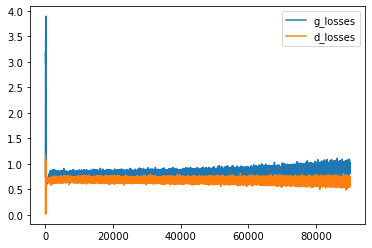

In [43]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

In [44]:
!ls gan_images

0.png	   13800.png  17800.png  21600.png  25600.png  29600.png  6600.png
10000.png  14000.png  18000.png  21800.png  25800.png  29800.png  6800.png
1000.png   1400.png   1800.png	 22000.png  26000.png  3000.png   7000.png
10200.png  14200.png  18200.png  2200.png   2600.png   3200.png   7200.png
10400.png  14400.png  18400.png  22200.png  26200.png  3400.png   7400.png
10600.png  14600.png  18600.png  22400.png  26400.png  3600.png   7600.png
10800.png  14800.png  18800.png  22600.png  26600.png  3800.png   7800.png
11000.png  15000.png  19000.png  22800.png  26800.png  4000.png   8000.png
11200.png  15200.png  19200.png  23000.png  27000.png  400.png	  800.png
11400.png  15400.png  19400.png  23200.png  27200.png  4200.png   8200.png
11600.png  15600.png  19600.png  23400.png  27400.png  4400.png   8400.png
11800.png  15800.png  19800.png  23600.png  27600.png  4600.png   8600.png
12000.png  16000.png  20000.png  23800.png  27800.png  4800.png   8800.png
1200.png   1600.png   2000.png

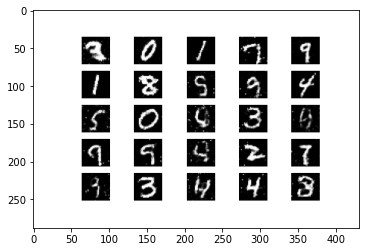

In [46]:
from skimage.io import imread
a = imread('gan_images/0.png')
plt.imshow(a)

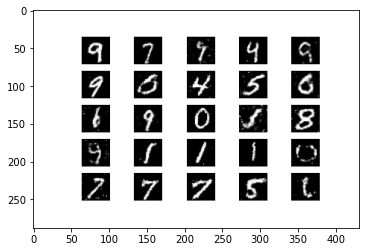

In [47]:
a = imread('gan_images/1000.png')
plt.imshow(a)

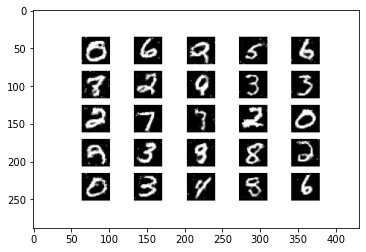

In [48]:
a = imread('gan_images/4000.png')
plt.imshow(a)

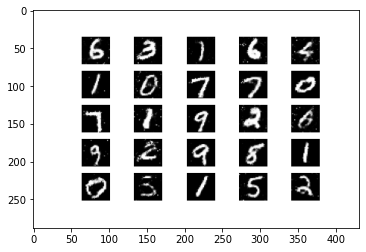

In [49]:
a = imread('gan_images/10000.png')
plt.imshow(a)

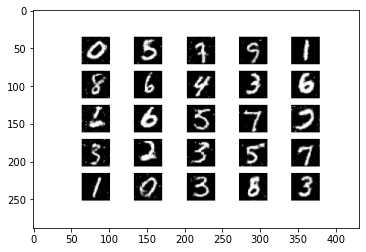

In [50]:
a = imread('gan_images/20000.png')
plt.imshow(a)

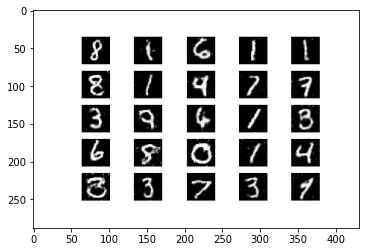

In [51]:
a = imread('gan_images/29800.png')
plt.imshow(a)